# 1. Context and data upload

Data comes from [fr.openfoodfacts.org](https://fr.openfoodfacts.org/), and is kindly provided as a download-able [link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip) by Openclassrooms.

First step is to download the file from the url provided.

In [1]:
# Download the zip file
!wget 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'

--2023-09-08 06:41:59--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.37.131, 52.218.25.155, 52.218.105.130, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.37.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88117814 (84M) [application/x-www-form-urlencoded]
Saving to: ‘fr.openfoodfacts.org.products.csv.zip’

fr.openfoodfacts.or 100%[===================>]  84.04M  20.3MB/s    in 5.0s    

2023-09-08 06:42:04 (16.9 MB/s) - ‘fr.openfoodfacts.org.products.csv.zip’ saved [88117814/88117814]



In [2]:
# Import the packages used

# Unzipping
from zipfile import ZipFile
# Work on data
import numpy as np
import pandas as pd
# Plot missing values
import missingno as msno
# Missing values imputation
from sklearn.impute import KNNImputer
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Then, within the folder, select the csv file and create the dataset

# Select the zip file:
with ZipFile("fr.openfoodfacts.org.products.csv.zip", 'r') as zObject:
  # Select the CSV file:
    with zObject.open("fr.openfoodfacts.org.products.csv") as myFile:
        # Read the file and create the dataset:
        init_data = pd.read_csv(myFile,
                                sep='\t',
                                encoding='utf-8')
zObject.close()

<ipython-input-3-80c7b8d75ad1>:8: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  init_data = pd.read_csv(myFile,


In [4]:
# These dtypes should be fixed for further analysis (warning from previous cell)
init_data.iloc[:, [0, 3, 5, 19, 20, 24, 25, 26, 27, 28, 35, 36, 37, 38, 39, 48
                   ]].sample(5, random_state=7)

,code,created_t,last_modified_t,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,allergens,allergens_fr,traces,traces_tags,traces_fr,ingredients_from_palm_oil_tags
71658,70640011841,1489090944,1489090944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230205,3388690001123,1427633778,1427638829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191966,3068112300125,1430396595,1430400235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blé,NaN,"oeufs,lait,soja,graines de sésame,fruits à coque","en:eggs,en:milk,en:nuts,en:sesame-seeds,en:soy...","Œufs,Lait,Fruits à coque,Graines de sésame,Soja",NaN
153387,819893024112,1489074930,1489074930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51364,41500819389,1489056631,1489056631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Overview of the data and pre-selection of the columns

The main idea here is:
- determine which are the most determining variables for the Nutri-Score,
- knowing the value of some of these variables for a given product, is it possible to predict its Nutri-Score?

According to its [definition](https://en.wikipedia.org/wiki/Nutri-Score), the Nutri-Score is calculated as __total N score - total P score = Nutritional score__:
- Product ingredients negatively (__N__) affecting the Nutri-Score:
  - Energy density (kcal/100g, kcal/100ml for beverages),
  - Simple sugars (g/100g, g/100ml for beverages),
  - Saturated fats (g/100g, % for cooking fats),
  - Salt (mg/100g),
- Product ingredients positively (__P__) affecting the Nutri-Score:
  - Fruit, vegetables, nuts and legumes (%),
  - Fibre (g/100g),
  - Protein (g/100g),
  - Rapeseed, walnut and olive oil (unit TBD).

Score ranges from -15 to +40, the lower the value the better the quality.

These are the columns I keep at minima.

The variables are defined [here](https://world.openfoodfacts.org/data/data-fields.txt).

In [5]:
# Let's have a look at the shape first:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 320772 rows and 162 columns


In [6]:
# Display all the columns for analysis
pd.set_option('display.max_columns', init_data.shape[1]+1)
# Set the column width
pd.set_option('display.max_colwidth', 40)

init_data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/pr...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-fac...","en:to-be-completed,en:nutrition-fact...","A compléter,Informations nutritionne...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/pr...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil,...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ] [ veget...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,d,NaN,NaN,"en:to-be-completed,

## 2.1. Columns selection (a priori)

In [7]:
# Select the columns that interest me, a priori.
# The others can be added back for a more extensive analysis:
selected_cols = [
    'product_name', 'labels', 'labels_tags', 'labels_fr', 'countries_fr',
    'ingredients_text', 'additives', 'nutrition_grade_fr', 'pnns_groups_1',
    'pnns_groups_2', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
    'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g',
    'omega-6-fat_100g', 'omega-9-fat_100g', 'cholesterol_100g',
    'carbohydrates_100g', 'sugars_100g' ,'fiber_100g', 'proteins_100g',
    'salt_100g', 'sodium_100g', 'alcohol_100g', 'fruits-vegetables-nuts_100g',
    'nutrition-score-fr_100g']

In [8]:
# Filter the data
selected_df = init_data[selected_cols]
selected_df.shape

(320772, 28)

## 2.2. Select the rows sold, at least, in France
* Using the column 'countries_fr'

In [9]:
# First, fill the missing values of that column
selected_df['countries_fr'] = selected_df['countries_fr'].fillna('UNK')

<ipython-input-9-9f5ed23bd733>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['countries_fr'] = selected_df['countries_fr'].fillna('UNK')


In [10]:
# Let's filter the data for the rows where the Country contains "France"
french_df = selected_df[selected_df['countries_fr'].str.contains('France')]
french_df.shape

(98440, 28)

In [11]:
# We can now drop this column
french_df_drop = french_df.drop(columns='countries_fr')

## 2.3. Filter out the rows with no data for the Nutri Score
* If the prediction is possible, maybe add these rows back and predict the Nutri Score

In [12]:
# Let's see how many rows are empty for the Nutri Score
col_1 = 'nutrition_grade_fr'
col_2 = 'nutrition-score-fr_100g'

print(f"There are {french_df_drop[col_1].isna().sum()} empty rows for the \
column {col_1} and {french_df_drop[col_2].isna().sum()} empty rows for the \
column {col_2}")

There are 37025 empty rows for the column nutrition_grade_fr and 37025 empty rows for the column nutrition-score-fr_100g


This looks like these are the same rows, but let's confirm.

In [13]:
# Col_1 is empty while col_2 is not:
french_df_drop[french_df_drop[col_1].isna() & ~french_df_drop[col_2].isna()]

,product_name,labels,labels_tags,labels_fr,ingredients_text,additives,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


In [14]:
# Col_1 is not empty while col_2 is:
french_df_drop[~french_df_drop[col_1].isna() & french_df_drop[col_2].isna()]

,product_name,labels,labels_tags,labels_fr,ingredients_text,additives,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


In [15]:
# Select either to filter the data.
# That's a huge loss (~37%), but enough data remains:
french_nutri_df = french_df_drop[~french_df_drop[col_1].isna()]
french_nutri_df.shape

(61415, 27)

## 2.4. Work on the label(s)

In [16]:
# Let's investigate the labels
col_1 = 'labels'
col_2 = 'labels_tags'
col_3 = 'labels_fr'

french_nutri_df[[col_1, col_2, col_3]].sample(10, random_state=13)

,labels,labels_tags,labels_fr
245040,Produit en braille,en:in-braille,Produit en braille
245284,"Peu ou pas de sucre,Point Vert,Fabri...","en:low-or-no-sugar,en:green-dot,en:m...","Peu ou pas de sucre,Point Vert,Fabri..."
240949,NaN,NaN,NaN
239728,"Labels de distributeurs,Qualité Carr...","en:labels-of-distributors,en:carrefo...","Labels de distributeurs,Qualité Carr..."
313361,"Sans conservateurs,Non fabriqué à l'...","en:no-preservatives,fr:non-fabrique-...","Sans conservateurs,Non-fabrique-a-l-..."
193602,"Viande Française,Sans OGM,Viande Por...","en:no-gmos,fr:viande-francaise,fr:vi...","Sans OGM,Viande Française,Viande Por..."
195373,NaN,NaN,NaN
188266,"Sans bisphénol-A,Sans gluten","en:gluten-free,en:no-bisphenol-a","Sans gluten,Sans bisphénol-A"
194585,Fournisseur breveté de la cour de Be...,fr:fournisseur-brevete-de-la-cour-de...,Fournisseur-brevete-de-la-cour-de-be...
205284,"Sélection Intermarché,Point Vert","en:labels-of-distributors,en:green-d...","Labels de distributeurs,Point Vert,S..."


There seems to be some information in here. This can be used to extract whether a product is Bio, Organic, GMO, BPA-free, etc.

In [17]:
# I will not use them here, at least for now:
rmv_labels = french_nutri_df.drop(columns=[col_1, col_2, col_3])
rmv_labels.shape

(61415, 24)

## 2.5 Work on the ingredients and the additives

In [18]:
# Define the columns and get a sample
col_1 = 'ingredients_text'
col_2 = 'additives'

rmv_labels[[col_1, col_2]].sample(10, random_state=13)

,ingredients_text,additives
245040,NaN,NaN
245284,Jus d'ananas.,[ jus-d-ananas -> fr:jus-d-ananas ...
240949,"Lait entier 98%, lactose et protéine...",[ lait-entier-98 -> fr:lait-entier-...
239728,Riz long grain étuvé de qualité supé...,[ riz-long-grain-etuve-de-qualite-s...
313361,"Pommes de terre (96 %), assaisonneme...",[ pommes-de-terre -> fr:pommes-de-t...
193602,Filet de porc issu d'animaux nourris...,[ filet-de-porc-issu-d-animaux-nour...
195373,NaN,NaN
188266,"pomme 77,4%, banane 20,4%, sucre, an...",[ pomme-77 -> fr:pomme-77 ] [ pom...
194585,"Farine de blé, sucre, chocolat au la...",[ farine-de-ble -> fr:farine-de-ble...
205284,"Haricots verts extra-fins, eau, sel.",[ haricots-verts-extra-fins -> fr:h...


There seems to be some information in here. This can be used to extract whether a product contains milk, almonds, etc.

In [19]:
# I will not use them here, at least for now:
base_df = rmv_labels.drop(columns=[col_1, col_2])
base_df.shape

(61415, 22)

# 3. Data preparation (cleaning and completion)

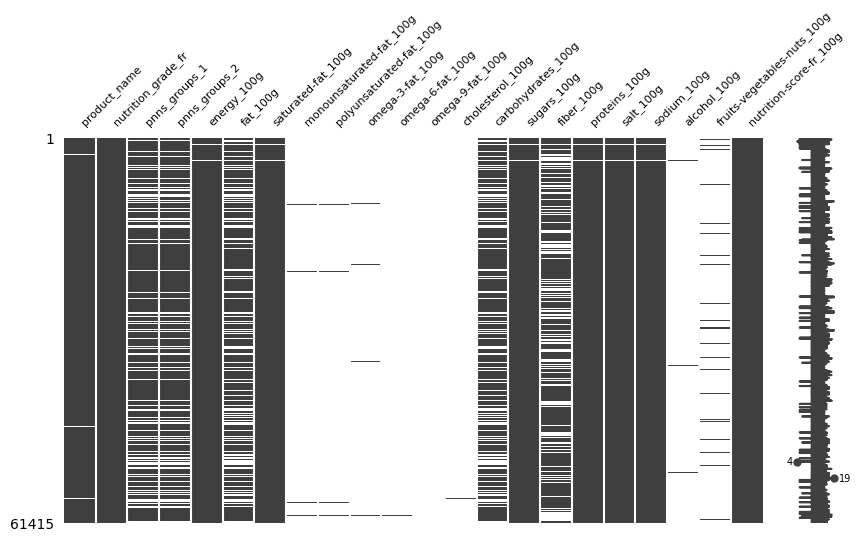

In [20]:
# Let's have an idea of the completion, visually
_ = msno.matrix(df=base_df, figsize=(10,5), fontsize=8)

In [21]:
# Although a different way of doing this would be to create a column encoding
# the missingness, or trying to impute values, I delete the following
# columns for being too empty:
empty_cols = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
              'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g',
              'cholesterol_100g', 'alcohol_100g']

base_df_rmv = base_df.drop(columns=empty_cols)

In [22]:
# For the fruits-veg column, since I need it, I will create a new column to
# encode the missingness, and fill the missing values with 0

# First, create the new column
base_df_rmv['fruits-veg-missing'] = base_df_rmv[
    'fruits-vegetables-nuts_100g'].isna()

# Then, fill the missing values
base_df_rmv['fruits-vegetables-nuts_100g'] = base_df_rmv[
    'fruits-vegetables-nuts_100g'].fillna(0)

In [23]:
# Let's remove the duplicates (if any).
# Ignore_index to reset the index:
base_df_rmv.drop_duplicates(inplace=True, ignore_index=True)
base_df_rmv.shape

(60596, 16)

## 3.1. Outliers and sanity checks

### 3.1.1. Quantities

In [24]:
# Define list of quantitative columns
quant_cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
              'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
              'proteins_100g', 'salt_100g', 'sodium_100g',
              'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g']

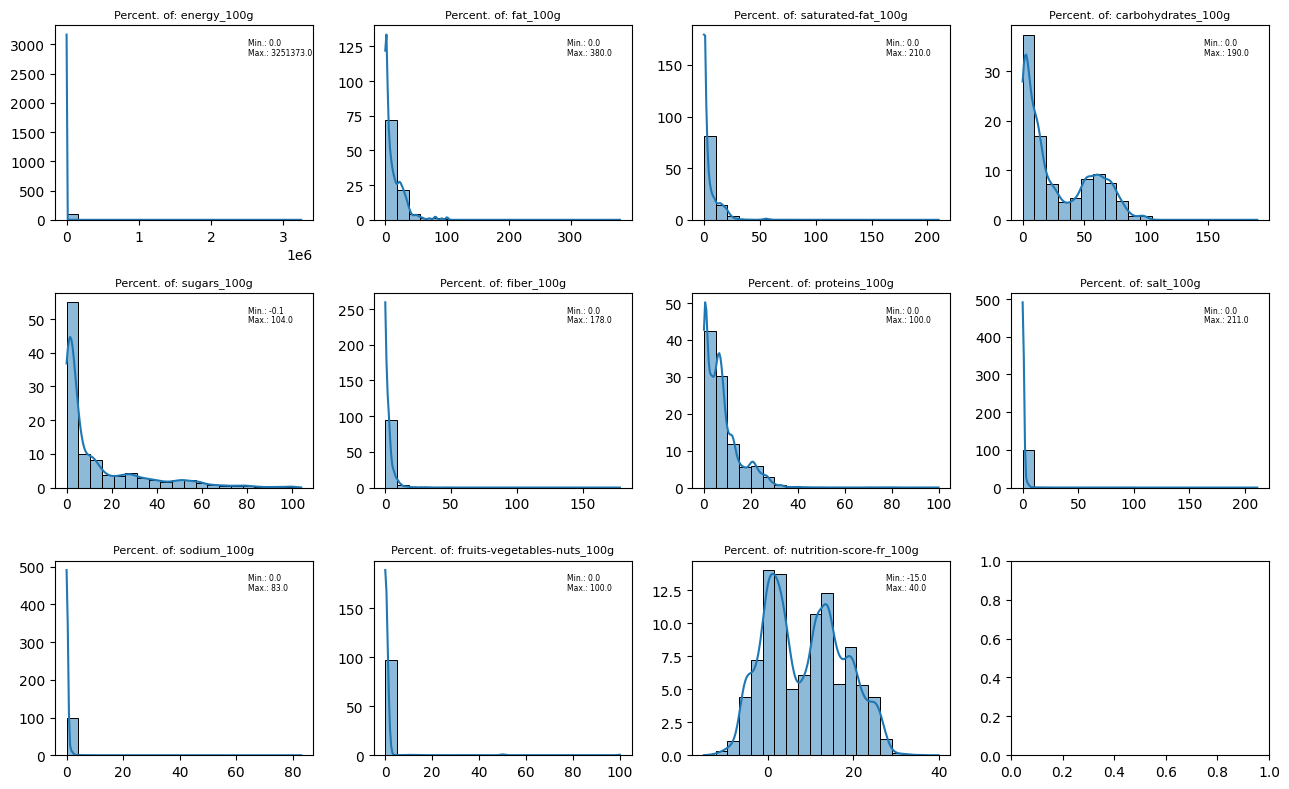

In [25]:
# Let's start by representing each variable with a histogram

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 4)
for i in range(len(quant_cols)):
  sns.histplot(base_df_rmv, x=quant_cols[i], stat='percent', bins=20, kde=True,
               ax=axs[i//4, i%4])
  # Remove x and y axis names
  axs[i//4, i%4].set(xlabel='', ylabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=8)
  # Add min and max within the subplots
  axs[i//4, i%4].text(0.75, 0.9,
                      'Min.: {}'.format(base_df_rmv[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
  axs[i//4, i%4].text(0.75, 0.85,
                      'Max.: {}'.format(base_df_rmv[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

There seems to be some outliers / high/abnormal values for the following columns:
* energy_100g
* fat_100g
* saturated-fat_100g
* carbohydrates_100g
* sugars_100g
* fiber_100g
* salt_100g

In [26]:
# Define the list to investigate:
check_outliers = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                  'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                  'salt_100g']

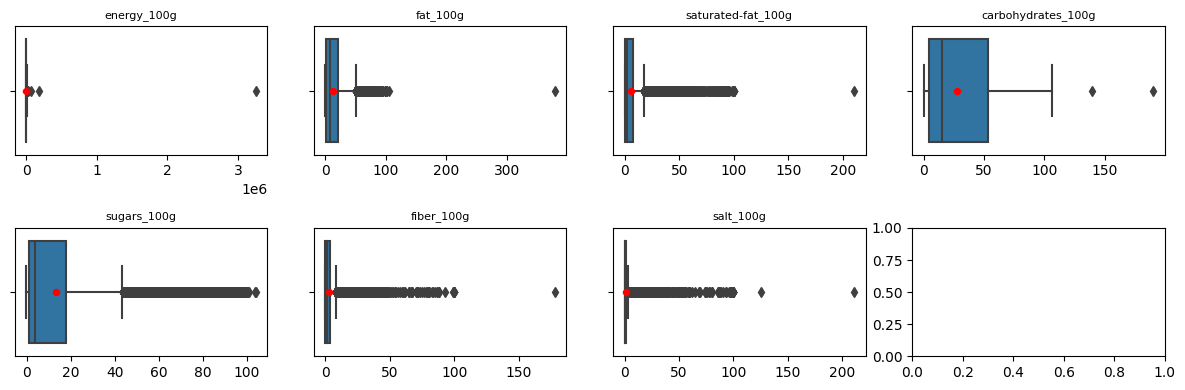

In [27]:
# Now let's represent these variables with a boxplot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (12,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(2, 4)
for i in range(len(check_outliers)):
  sns.boxplot(base_df_rmv, x=check_outliers[i], orient='h', ax=axs[i//4, i%4],
              showmeans=True, meanprops={'marker':'8',
                                         'markerfacecolor':'red',
                                         'markeredgecolor':'red',
                                         'markersize':'5'})
  # Remove x axis name
  axs[i//4, i%4].set(xlabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title(check_outliers[i], fontsize=8)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

I will now examine the outliers one by one, because there could be a different reason for each column.

In case there is a "generic" explanation (define upper/lower boundaries and set the outliers to np.nan for instance), a function to apply might be considered for automation.

#### Outliers for energy

In [28]:
# Start by making a copy of the df
outliers_df = base_df_rmv.copy()

In [29]:
# Let's start by examining the outlier for the energy.
# 1000 should be a high value already:
col_ = 'energy_100g'

len(outliers_df[outliers_df[col_]>=1_000])
#outliers_df[outliers_df[col_]>=1_000].sort_values(by=[col_], ascending=False)

31484

That's a lot of rows, almost 50% of the remaining data! Maybe there's more to it.

In [30]:
# This seems to be expressed in kj (that's my guess), so I will need to convert
# it in kcal. Let's start with this:
outliers_df['energy_kcal_100g'] = round(outliers_df[col_]/4.184, 2)

In [31]:
# Drop the unused column
outliers_df.drop(columns=col_, inplace=True)
outliers_df.head()

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
0,Lion Peanut x2,e,unknown,unknown,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038000,0.0,22.0,True,450.05
1,Mini Confettis,d,NaN,NaN,NaN,0.8,NaN,87.7,0.9,0.6,0.01000,0.003937,0.0,14.0,True,418.98
2,Praliné Amande Et Noisette,d,NaN,NaN,NaN,2.9,NaN,50.3,3.9,9.5,0.00300,0.001181,0.0,14.0,True,575.05
3,"Pepsi, Nouveau goût !",e,Beverages,Sweetened beverages,0.0,0.0,10.4,10.4,0.0,0.0,0.02540,0.010000,0.0,13.0,True,42.30
4,Tarte Poireaux Et Lardons,d,NaN,NaN,NaN,11.0,NaN,1.0,1.4,7.5,0.80000,0.314961,0.0,15.0,True,257.89


In [32]:
# Let's have a new look at it
col_ = 'energy_kcal_100g'

len(outliers_df[outliers_df[col_]>1_000])
#outliers_df[outliers_df[col_]>1_000].sort_values(by=[col_], ascending=False)

73

That's more reasonable.

In [33]:
# I could decide to remove the values and then try to impute,
# or I could delete the rows, which is what I go for:
outliers_df = outliers_df[outliers_df[col_]<=1_000]
outliers_df.shape

(60445, 16)

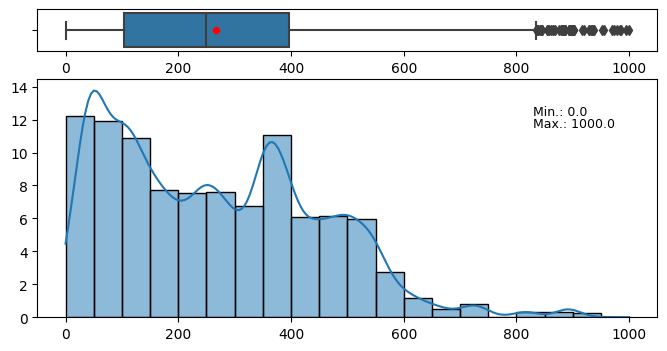

In [42]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)

_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for fat
* I am assuming a product like butter is 100% fat, so 100g is the upper boundary. This can be refined with domain knowledge.

In [43]:
# Let's start by examining the outliers for the fat
# 100 should be a high value:
col_ = 'fat_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
57484,Graine de couscous moyen,a,Cereals and potatoes,Cereals,105.0,0.3,70.0,2.5,NaN,12.0,0.01,0.003937,0.0,-1.0,True,354.21


In [44]:
# This seems to be a mistake. I'll set the value as np.nan:
outliers_df[col_][outliers_df[col_]>100] = np.nan

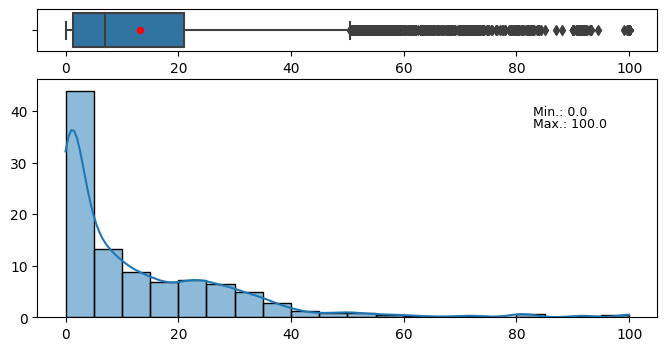

In [45]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for saturated fat
* Same assumption for the upper boundary

In [46]:
# Let's start by examining the outliers for the saturated fat.
# 100 should be a high value:
col_ = 'saturated-fat_100g'

len(outliers_df[outliers_df[col_]>100])
#outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

0

Looks like the problematic rows disappeared (one of the one deleted row from the energy)!

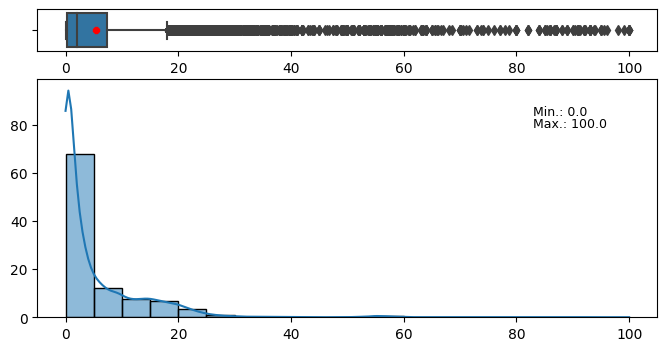

In [47]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### High values for carbohydrates
* Same assumption for the upper boundary

In [48]:
# Let's start by examining the high values for the carbohydrates.
# 100 should be a high value:
col_ = 'carbohydrates_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
60352,Banane sèche,c,Fruits and vegetables,Dried fruits,0.0,0.0,139.0,41.5,0.0,5.0,0.00000,0.00000,0.0,4.0,True,300.91
35183,Palets pur beurre,e,Sugary snacks,Biscuits and cakes,52.0,35.5,106.0,52.0,3.0,10.0,1.30048,0.51200,0.0,31.0,True,938.10
14399,Sirop d'Agave brun bio,d,unknown,unknown,0.0,0.0,104.0,104.0,0.0,0.0,0.14000,0.05510,0.0,15.0,True,420.65
48880,Sirop d agave pur,d,unknown,unknown,1.0,0.1,103.5,103.5,NaN,1.0,0.10000,0.03937,0.0,15.0,True,420.65
59870,NaN,d,unknown,unknown,0.0,0.0,100.8,100.8,0.0,0.0,0.42672,0.16800,0.0,16.0,True,409.66


Again, I could set the values to np.nan and then impute, or I could modify the value to 100 (upper boundary). For simplicity, and since this does not impact many rows, I delete them.

In [49]:
outliers_df = outliers_df.drop(index=[14399, 35183, 48880, 59870, 60352])
outliers_df.shape

(60440, 16)

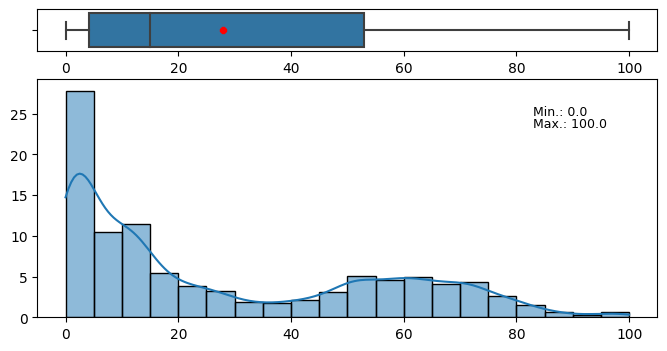

In [50]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Abnormal values for sugars
* Same assumption for the upper boundary, also valid for the lower boundary (value can not be negative)

In [51]:
# Let's start by examining the negative values for the sugars.
# 0 should be the minimum:
col_ = 'sugars_100g'

#len(outliers_df[outliers_df[col_]<0])
outliers_df[outliers_df[col_]<0].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
10095,Caprice des dieux,d,Milk and dairy products,Cheese,30.0,21.0,0.8,-0.1,NaN,15.3,1.4,0.551181,0.0,15.0,True,329.59


In [52]:
# This looks like a mistake. I'll set the value as 0:
outliers_df[col_][outliers_df[col_]<0] = 0

<ipython-input-52-f57801a28c3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_][outliers_df[col_]<0] = 0


In [53]:
# Let's now examine the high values for the sugars.
# 100 should be a high value:
len(outliers_df[outliers_df[col_]>100])
#outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

0

It looks like the rows got deleted already.

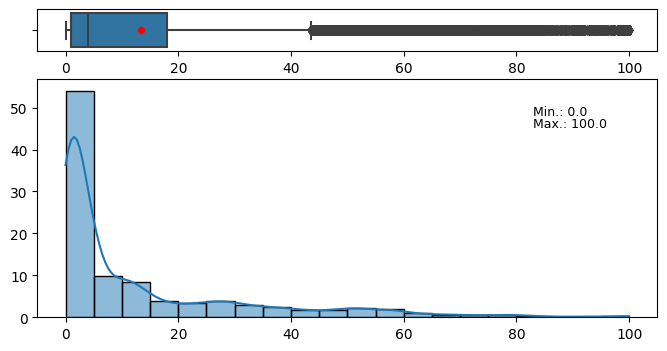

In [54]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for fiber
* Same assumption for the upper boundary

In [55]:
# Let's start by examining the outliers for the fiber.
# 100 should be a high value:
col_ = 'fiber_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
55912,Milka Schmunzelhase Alpenmilch 175G,e,unknown,unknown,29.0,18.0,59.0,58.0,178.0,6.3,0.37,0.145669,0.0,22.0,False,530.11


I'm guessing the nutritional values here are entered for the product, therefore for 175g. I could divide the values of the row by 1.75, but since I'm not 100% sure that all the values are impacted I delete the row.

In [56]:
outliers_df = outliers_df.drop(index=[55912])
outliers_df.shape

(60439, 16)

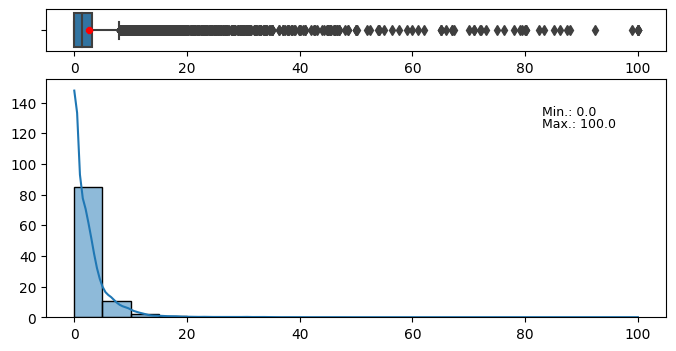

In [57]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for salt
* Same assumption for the upper boundary

In [58]:
# Let's start by examining the outliers for the salt.
# 100 should be a high value:
col_ = 'salt_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
33840,Keeny Bio,e,Sugary snacks,Biscuits and cakes,23.0,3.33,47.8,26.7,0.741,6.3,211.0,83.000000,0.0,22.0,True,411.09
34395,Sel de Guérande Label Rouge,c,unknown,unknown,0.0,0.00,0.0,0.0,0.000,0.0,125.0,49.212598,0.0,10.0,True,0.00


The values seem to be indicated for more than 100g. I just delete the rows for simplicity.

In [59]:
outliers_df = outliers_df.drop(index=[33840, 34395])
outliers_df.shape

(60437, 16)

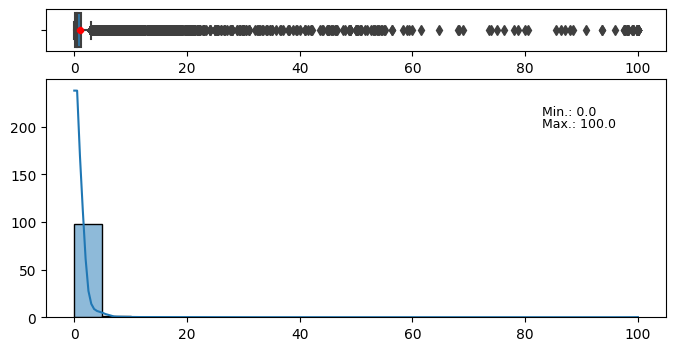

In [60]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

### 3.1.2. Qualitative variables

In [61]:
# Let's reset the index, and make a copy
outliers_df.reset_index(drop=True)
outliers_df2 = outliers_df.copy()

In [62]:
outliers_df2.head()

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
0,Lion Peanut x2,e,unknown,unknown,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038000,0.0,22.0,True,450.05
1,Mini Confettis,d,NaN,NaN,NaN,0.8,NaN,87.7,0.9,0.6,0.01000,0.003937,0.0,14.0,True,418.98
2,Praliné Amande Et Noisette,d,NaN,NaN,NaN,2.9,NaN,50.3,3.9,9.5,0.00300,0.001181,0.0,14.0,True,575.05
3,"Pepsi, Nouveau goût !",e,Beverages,Sweetened beverages,0.0,0.0,10.4,10.4,0.0,0.0,0.02540,0.010000,0.0,13.0,True,42.30
4,Tarte Poireaux Et Lardons,d,NaN,NaN,NaN,11.0,NaN,1.0,1.4,7.5,0.80000,0.314961,0.0,15.0,True,257.89


In [63]:
# Define the list of columns
quant_cols = ['product_name', 'nutrition_grade_fr',
              'pnns_groups_1', 'pnns_groups_2']

There are too many modalities for the product_name, I will not work on the column.

#### Nutrition grade
* As it is related to the Nutri Score, the values should only be A, B, C, D or E

In [64]:
# Check the values in the column
col_ = 'nutrition_grade_fr'

outliers_df2[col_].unique()

array(['e', 'd', 'c', 'a', 'b'], dtype=object)

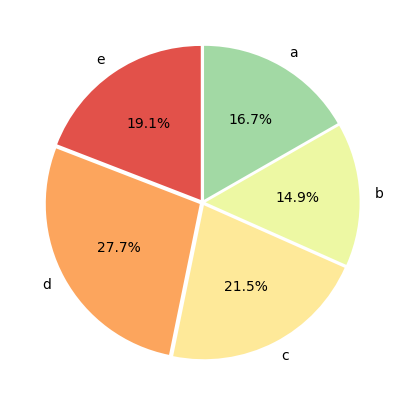

In [77]:
# Plot the repartition by group

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (5,5)

# Define the groups, plotted counterclockwise
nutri_groups = ['e', 'd', 'c', 'b', 'a']
# Define the spacing from the center
explode = [.02, .02, .02, .02, .02]
# Define the color palette
colors = sns.color_palette("Spectral")

# Create the plot
plt.pie(outliers_df2[col_].value_counts(normalize=True).reindex(nutri_groups),
        explode=explode, labels=nutri_groups, colors=colors, startangle=90,
        autopct='%1.1f%%')
plt.show()

# List of colors for subplots:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html

#### PNNS (Programme National Nutrition Sante)
* Related to a French national program. [Link to the 2019-2023 official sheet.](https://sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* Identifies categories of food to:
  * __Increase:__ dried vegetables, fresh fruits and vegetables, nuts
  * __Move towards:__ whole wheat bread, fishes, colza/nut/olive oil, dairy products,
  * __Reduce:__ cold cuts, too sweet/fat/salty products, alcohol, red meat.

In [78]:
# Check the values in the column pnns_1:
col_ = 'pnns_groups_1'

outliers_df2[col_].unique()

array(['unknown', nan, 'Beverages', 'Sugary snacks', 'Composite foods',
       'Fruits and vegetables', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'Cereals and potatoes',
       'Fish Meat Eggs', 'fruits-and-vegetables', 'sugary-snacks',
       'cereals-and-potatoes'], dtype=object)

From this:
* There is an 'unknown' modality => the missing values can be filled with this
* Some modalitites appear duplicate:
  * 'Sugary snacks' and 'sugary-snacks'
  * 'Fruits and vegetables' and 'fruits-and-vegetables'
  * 'Cereals and potatoes' and 'cereals-and-potatoes'

In [79]:
# Let's fill the missing values, with 'unknown'
outliers_df2['pnns_groups_1'] = outliers_df2['pnns_groups_1'].fillna('unknown')

In [86]:
# Regroup the modalities:

# Create the wanted mapping:
new_pnns_1 = {'Beverages':['Beverages'],
              'Cereals and potatoes':['Cereals and potatoes',
                                      'cereals-and-potatoes'],
              'Composite foods':['Composite foods'],
              'Fat and sauces':['Fat and sauces'],
              'Fish Meat Eggs':['Fish Meat Eggs'],
              'Fruits and vegetables':['Fruits and vegetables',
                                       'fruits-and-vegetables'],
              'Milk and dairy products':['Milk and dairy products'],
              'Salty snacks':['Salty snacks'],
              'Sugary snacks':['Sugary snacks', 'sugary-snacks'],
              'UNK':['unknown']}

# Reverse it for use:
map_pnns_1 = {k: oldk for oldk, oldv in new_pnns_1.items() for k in oldv}

# Apply it
outliers_df2['pnns_groups_1'] = outliers_df2['pnns_groups_1'].map(map_pnns_1)

In [91]:
list(new_pnns_1.keys())

['Beverages',
 'Cereals and potatoes',
 'Composite foods',
 'Fat and sauces',
 'Fish Meat Eggs',
 'Fruits and vegetables',
 'Milk and dairy products',
 'Salty snacks',
 'Sugary snacks',
 'Unknown']

In [102]:
outliers_df2[col_].value_counts(normalize=True)

Unknown                    0.351291
Sugary snacks              0.126429
Milk and dairy products    0.084088
Cereals and potatoes       0.083839
Composite foods            0.082880
Fish Meat Eggs             0.074706
Beverages                  0.071016
Fruits and vegetables      0.051111
Fat and sauces             0.045072
Salty snacks               0.029568
Name: pnns_groups_1, dtype: float64

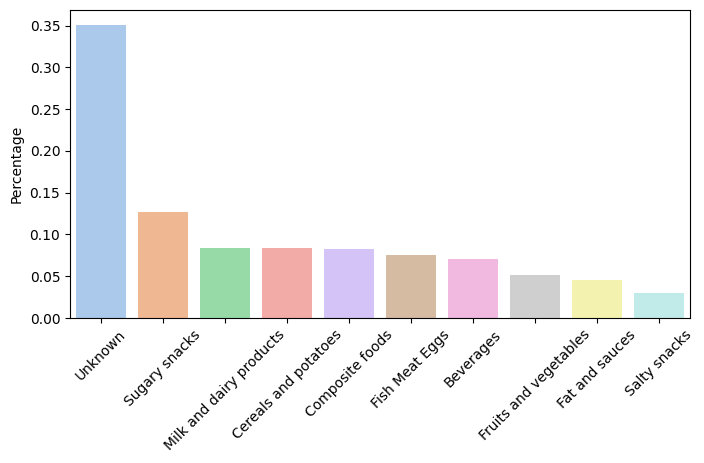

In [115]:
# Plot the repartition by group

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)

# Define the color palette
colors = sns.color_palette("pastel")

# Create the plot
ax = sns.barplot(data=outliers_df2,
                 x=outliers_df2[col_].value_counts(normalize=True).index,
                 y=outliers_df2[col_].value_counts(normalize=True),
                 palette=colors)
ax.set(ylabel='Percentage')
plt.xticks(rotation=45)
plt.show()

In [116]:
# Check the values in the column pnns_2:
col_ = 'pnns_groups_2'

outliers_df2[col_].unique()

array(['unknown', nan, 'Sweetened beverages', 'Biscuits and cakes',
       'One-dish meals', 'Soups', 'Non-sugared beverages', 'Cheese',
       'Sweets', 'Sandwich', 'Dressings and sauces', 'Appetizers', 'Nuts',
       'Dried fruits', 'Breakfast cereals', 'Pizza pies and quiche',
       'Fruits', 'Fruit juices', 'Cereals', 'Vegetables', 'Bread',
       'Chocolate products', 'Processed meat', 'Legumes', 'vegetables',
       'Ice cream', 'Fish and seafood', 'pastries', 'Milk and yogurt',
       'Dairy desserts', 'Meat', 'Fats',
       'Artificially sweetened beverages', 'Fruit nectars', 'Potatoes',
       'Alcoholic beverages', 'Salty and fatty products', 'Tripe dishes',
       'Eggs', 'fruits', 'cereals'], dtype=object)

There is some interesting information here. I would first need to fill in the blanks (with 'unknown), then some grouping.

I will not use these categories here, the PNNS level 1 will be enough.

In [118]:
# I just drop the column:
outliers_fin = outliers_df2.drop(columns=col_)
outliers_fin.shape

(60437, 15)

## 3.2. Correlation

In [160]:
# Let's make a copy
cor_df = outliers_fin.copy()

In [161]:
# Check the dtypes to include: here the float64
cor_df.dtypes

product_name                    object
nutrition_grade_fr              object
pnns_groups_1                   object
fat_100g                       float64
saturated-fat_100g             float64
carbohydrates_100g             float64
sugars_100g                    float64
fiber_100g                     float64
proteins_100g                  float64
salt_100g                      float64
sodium_100g                    float64
fruits-vegetables-nuts_100g    float64
nutrition-score-fr_100g        float64
fruits-veg-missing                bool
energy_kcal_100g               float64
dtype: object

In [163]:
num_df = cor_df.select_dtypes(include=['float64', 'bool'])
num_df.shape

(60437, 12)

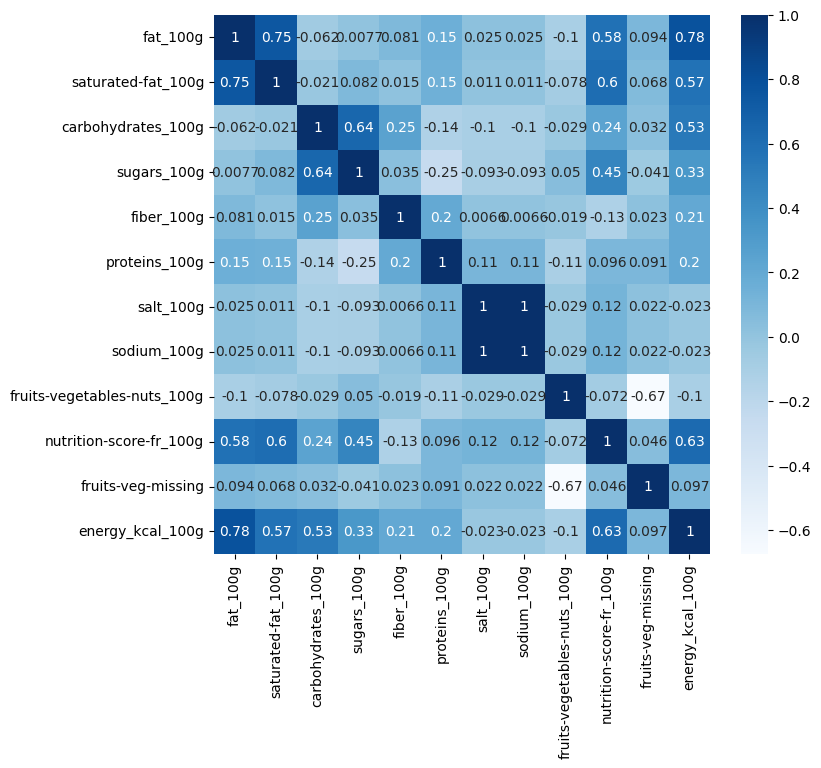

In [164]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,7)

# Create the plot
ax = sns.heatmap(num_df.corr(), cmap='Blues', annot=True)
plt.show()

From this, it appears that some variables highly influence others (vs energy or even vs nutriscore, which needs to be explored).

Also, we see that salt and sodium carry the same information, so the emptiest one can be dropped.

In [165]:
# Let's remove the sodium
cor_df = cor_df.drop(columns='sodium_100g')

## 3.3. Missing values

In [174]:
# Let's make a copy
mis_val_df = cor_df.copy()

### Qualitative variables
* The blanks can be filled with something like 'UNK', unless there already is a modality encoding the missingness

In [175]:
mis_val_df.columns

Index(['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts_100g',
       'nutrition-score-fr_100g', 'fruits-veg-missing', 'energy_kcal_100g'],
      dtype='object')

In [176]:
# Check if there are missing values
mis_val_df['product_name'].isna().sum()

336

In [177]:
# Fill with 'UNK
mis_val_df['product_name'].fillna('UNK', inplace=True)

In [178]:
# Check if there are missing values
mis_val_df['nutrition_grade_fr'].isna().sum()

0

### Quantitative variables
* There are different ways of 'filling the blanks', like imputing the mean (or median) or using an imputer like IterativeImputer, KNNImputer, etc.
* I'll go with the KNNImputer here.

In [179]:
# Define the imputer. I keep the default parameters (n=5):
imputer = KNNImputer()

In [182]:
# Select the subset to be imputed
imputed = mis_val_df.select_dtypes(include=['float64', 'bool'])

In [203]:
# Train on the numerical columns, and transform (~2 mins)
filling = imputer.fit_transform(imputed)

In [204]:
# Replace the newly imputed values
mis_val_df.iloc[:, 3:] = filling

In [205]:
# Check that no missing value remains
mis_val_df.isnull().sum()

product_name                   0
nutrition_grade_fr             0
pnns_groups_1                  0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
fruits-veg-missing             0
energy_kcal_100g               0
dtype: int64

Let's also confirm visually that the profiles remain similar.

In [212]:
# Define list of quantitative columns
quant_cols = list(mis_val_df.select_dtypes(include=['float64']).columns)

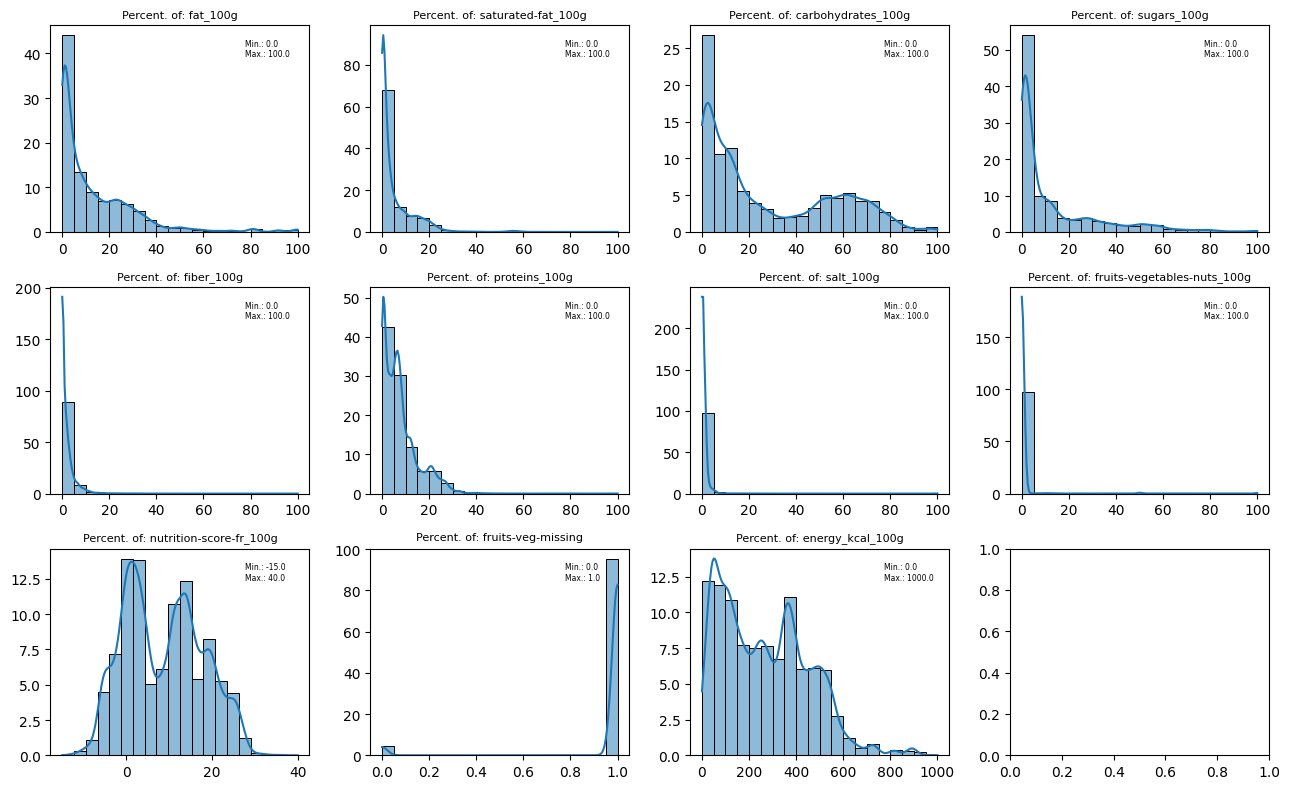

In [213]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 4)
for i in range(len(quant_cols)):
  sns.histplot(mis_val_df, x=quant_cols[i], stat='percent', bins=20, kde=True,
               ax=axs[i//4, i%4])
  # Remove x and y axis names
  axs[i//4, i%4].set(xlabel='', ylabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=8)
  # Add min and max within the subplots
  axs[i//4, i%4].text(0.75, 0.9,
                      'Min.: {}'.format(mis_val_df[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
  axs[i//4, i%4].text(0.75, 0.85,
                      'Max.: {}'.format(mis_val_df[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

# 4. File export

In [220]:
# Start by making a copy
exported = mis_val_df.copy()

In [222]:
# Let's start by rounding the imputed columns to 2 decimals
exported = round(exported, 2)

In [223]:
exported.head()

,product_name,nutrition_grade_fr,pnns_groups_1,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
0,Lion Peanut x2,e,Unknown,20.00,12.5,70.00,57.5,2.5,2.5,0.10,0.0,22.0,1.0,450.05
1,Mini Confettis,d,Unknown,4.50,0.8,92.46,87.7,0.9,0.6,0.01,0.0,14.0,1.0,418.98
2,Praliné Amande Et Noisette,d,Unknown,36.48,2.9,47.90,50.3,3.9,9.5,0.00,0.0,14.0,1.0,575.05
3,"Pepsi, Nouveau goût !",e,Beverages,0.00,0.0,10.40,10.4,0.0,0.0,0.03,0.0,13.0,1.0,42.30
4,Tarte Poireaux Et Lardons,d,Unknown,17.42,11.0,17.30,1.0,1.4,7.5,0.80,0.0,15.0,1.0,257.89


In [225]:
# Let's also re-order the columns
exported = exported.loc[:, ['product_name', 'energy_kcal_100g', 'fat_100g',
                            'saturated-fat_100g', 'carbohydrates_100g',
                            'sugars_100g', 'fiber_100g', 'proteins_100g',
                            'salt_100g', 'fruits-vegetables-nuts_100g',
                            'fruits-veg-missing', 'nutrition-score-fr_100g',
                            'nutrition_grade_fr', 'pnns_groups_1']]
exported.shape

(60437, 14)

In [226]:
# Finally, generate a csv file to be used for the next part
exported.to_csv("food_data_reworked.csv", sep='\t', index=False)

Next step is to upload the file to GitHub, to be accessed easily.